<center><h1> Problem2 - CNN on MNIST </h1><center>

### Import the required packages

In [1]:
import tensorflow as tf

#To check if tensorflow can access the gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

from google.colab import files

Found GPU at: /device:GPU:0


### Load MNIST Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Check the train-valid-test data size

In [3]:
print("Num of samples-Train: {}".format(len(data.train.labels)))
print("Num of samples-Test: {}".format(len(data.test.labels)))
print("Num of samples-Valid: {}".format(len(data.validation.labels)))

Num of samples-Train: 55000
Num of samples-Test: 10000
Num of samples-Valid: 5000


### Initalization of the placeholder variables

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
x_image = tf.reshape(x, [-1, 28, 28, 1])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Functions to create basic CNN layers

In [0]:
#Create convolution layer
def conv_layer(input, num_input_channels, filter_size, num_filters, name):
    
    #Filter-shape
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Weights and Biases
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #weights = tf.Variable(tf.constant(0, shape))
    biases = tf.Variable(tf.constant(0.01, shape=[num_filters]))

    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases

    return layer, weights

#Create pool layer      
def pool_layer(input, name):
    
    layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    return layer

#Create ReLU Activation Layer
def relu_layer(input, name):

    layer = tf.nn.relu(input)

    return layer

#Create Fully Connected Layer
def fc_layer(input, num_inputs, num_outputs, name):
    
    weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
    biases = tf.Variable(tf.constant(0.01, shape=[num_outputs]))

    layer = tf.matmul(input, weights) + biases

    return layer

###Convolutional Neural Network - Architecture for Classification - 6 Conv layers

Referred architecture : https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

Made changes in architecture and the trainable parameters to make the parameter count more or less similar to the MLP used in the previous question.

|MLP parameter count|CNN parameter count|
|:-----------------------------------:|:-----------------------------------:|
|937482|937972|




In [7]:
# Convolution 1
conv1, weights_conv1 = conv_layer(input=x_image, num_input_channels=1, filter_size=9, num_filters=16, name ="conv1")
pool1 = pool_layer(conv1, name="pool1")
relu1 = relu_layer(pool1, name="relu1")

# Convolution 2
conv2, weights_conv2 = conv_layer(input=relu1, num_input_channels=16, filter_size=9, num_filters=32, name= "conv2")
pool2 = pool_layer(conv2, name="pool2")
relu2 = relu_layer(pool2, name="relu2")

# Convolution 3
conv3, weights_conv3 = conv_layer(input=relu2, num_input_channels=32, filter_size=9, num_filters=42, name= "conv3")
pool3 = pool_layer(conv3, name="pool3")
relu3 = relu_layer(pool3, name="relu3")

# Convolution 4
conv4, weights_conv4 = conv_layer(input=relu3, num_input_channels=42, filter_size=9, num_filters=64, name= "conv3")
pool4 = pool_layer(conv4, name="pool4")
relu4 = relu_layer(pool4, name="relu4")

# Convolution 5
conv5, weights_conv5 = conv_layer(input=relu4, num_input_channels=64, filter_size=5, num_filters=128, name= "conv4")
pool5 = pool_layer(conv5, name="pool5")
relu5 = relu_layer(pool5, name="relu5")

# Convolution 6
conv6, weights_conv6 = conv_layer(input=relu5, num_input_channels=128, filter_size=3, num_filters=256, name= "conv5")
pool6 = pool_layer(conv6, name="pool6")
relu6 = relu_layer(pool6, name="relu6")

# Flatten Layer
num_features = relu6.get_shape()[1:4].num_elements()
flat = tf.reshape(relu6, [-1, num_features])

# Fully-Connected Layer 1
fc1 = fc_layer(flat, num_inputs=num_features, num_outputs= 256 , name="fc1")
relu7 = relu_layer(fc1, name="relu7")

# Fully-Connected Layer 2
fc2 = fc_layer(input=relu7, num_inputs = 256 , num_outputs=10, name="fc2")

Instructions for updating:
Colocations handled automatically by placer.


### Output Parameterization, Loss Calculation, Optimization ,Evaluation

In [0]:
# Use Softmax function to parameterize the output
y_pred = tf.nn.softmax(fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

# Evaluate model
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Set the n(epochs) and batch size

In [0]:
num_epochs = 10
batch_size = 64

trainloss, trainerror, validloss, validerror, epoch_n = ([] for i in range(5))

### TensorFlow Session - Start training for the specified n(epochs)




In [10]:
with tf.Session() as sess:
   
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        
        train_accuracy = 0
        train_loss     = 0
        
        for batch in range(0, int(len(data.train.labels)/batch_size)):
            
            # Take a batch of images and labels
            x_batch, y_true_batch = data.train.next_batch(batch_size)
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            
            # Run optimizer on each batch
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            # Accuracy and loss Calculation per batch
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            train_loss     += sess.run(cost, feed_dict=feed_dict_train) 
          
        train_accuracy /= int(len(data.train.labels)/batch_size)
        train_loss /= int(len(data.train.labels)/batch_size)
        
        # Validating the model on validation set
        vali_accuracy = sess.run(accuracy, feed_dict={x:data.validation.images, y_true:data.validation.labels})
        vali_loss = sess.run(cost, feed_dict={x:data.validation.images, y_true:data.validation.labels})
        
        print("\n Epoch :"+str(epoch+1))
        
        #To get Accuracy metrics  
        print("\t Accuracy:")
        print("\t-------")
        print ("\t Train Accuracy     :\t{}".format(train_accuracy))
        print ("\t Validation Accuracy:\t{}".format(vali_accuracy))
        
        #To get Loss metrics
        print("\t Loss:")
        print("\t------")
        print ("\t Train Loss     :\t{}".format(train_loss))
        print ("\t Validation Loss:\t{}".format(vali_loss))
        
        #To get Error metrics
        print("\t Error:")
        print("\t------")
        print ("\t Train Error     :\t{}".format(1-float(train_accuracy)))
        print ("\t Validation Error:\t{}".format(1-float(vali_accuracy)))
        
        trainloss.append(float(train_loss))
        validloss.append(float(vali_loss))
        trainerror.append(1-float(train_accuracy))
        validerror.append(1-float(vali_accuracy))
        epoch_n.append(int(epoch+1))
            
        


 Epoch :1
	 Accuracy:
	-------
	 Train Accuracy     :	0.4322977299185099
	 Validation Accuracy:	0.870199978351593
	 Loss:
	------
	 Train Loss     :	1.7216136253615613
	 Validation Loss:	0.44414326548576355
	 Error:
	------
	 Train Error     :	0.5677022700814901
	 Validation Error:	0.12980002164840698

 Epoch :2
	 Accuracy:
	-------
	 Train Accuracy     :	0.9418291618160652
	 Validation Accuracy:	0.9549999833106995
	 Loss:
	------
	 Train Loss     :	0.20585742979651975
	 Validation Loss:	0.14403410255908966
	 Error:
	------
	 Train Error     :	0.05817083818393476
	 Validation Error:	0.04500001668930054

 Epoch :3
	 Accuracy:
	-------
	 Train Accuracy     :	0.9790817811408614
	 Validation Accuracy:	0.9675999879837036
	 Loss:
	------
	 Train Loss     :	0.0807461429656211
	 Validation Loss:	0.1167488619685173
	 Error:
	------
	 Train Error     :	0.020918218859138582
	 Validation Error:	0.03240001201629639

 Epoch :4
	 Accuracy:
	-------
	 Train Accuracy     :	0.9885222642607684
	 Validat

### Get the parameter count and the best validation accuracy for the model

In [11]:
ParameterCount = np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])

print("\t Best Validation Accuracy is:\t{}".format(1-np.sort(validerror)[0]))
print("\t Total number of parameters is:\t{}".format(ParameterCount))

	 Best Validation Accuracy is:	0.9865999817848206
	 Total number of parameters is:	937972


### Plot train and validation loss per epoch

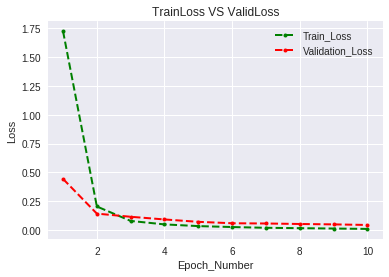

In [12]:
#Plot the train and valid loss at end of each epoch

p1=plt.plot(epoch_n, trainloss, label="trainloss", color='green', marker='o', linestyle='dashed',linewidth=2, markersize=4)
p2=plt.plot(epoch_n, validloss, label="valloss", color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.xlabel('Epoch_Number')
plt.ylabel('Loss')
plt.title('TrainLoss VS ValidLoss')
plt.legend((p1[0], p2[0]), ('Train_Loss', 'Validation_Loss'))
plt.savefig('TrainlossVSValloss.png', bbox_inches='tight')
files.download('TrainlossVSValloss.png')
plt.show() 


### Plot train and validation error per epoch

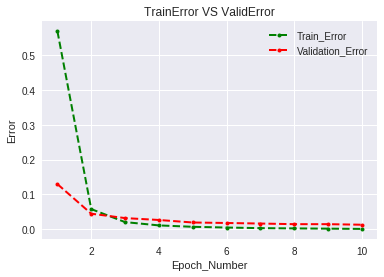

In [13]:
#Plot the train and valid error at end of each epoch

p1=plt.plot(epoch_n, trainerror, label="trainerror", color='green', marker='o', linestyle='dashed',linewidth=2, markersize=4)
p2=plt.plot(epoch_n, validerror, label="valerror", color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.xlabel('Epoch_Number')
plt.ylabel('Error')
plt.title('TrainError VS ValidError')
plt.legend((p1[0], p2[0]), ('Train_Error', 'Validation_Error'))
plt.savefig('TrainerrorVSValerror.png', bbox_inches='tight')
files.download('TrainerrorVSValerror.png')
plt.show() 

### Get all trainable tf variables along with shape 

taken from : https://stackoverflow.com/questions/38160940/how-to-count-total-number-of-trainable-parameters-in-a-tensorflow-model

In [15]:
total_parameters = 0
sum = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    print(shape)
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)


(9, 9, 1, 16)
1296
(16,)
16
(9, 9, 16, 32)
41472
(32,)
32
(9, 9, 32, 42)
108864
(42,)
42
(9, 9, 42, 64)
217728
(64,)
64
(5, 5, 64, 128)
204800
(128,)
128
(3, 3, 128, 256)
294912
(256,)
256
(256, 256)
65536
(256,)
256
(256, 10)
2560
(10,)
10
937972
